#**Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset seen in HW4.

In [1]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [2]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

170508288/170498071 [==============================] - 13s 0us/step


## [TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linealry combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [3]:
def SVD(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [4]:
ENCODING_DIM = 120

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [5]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [6]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00372
Test mse: 0.00375


In [7]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

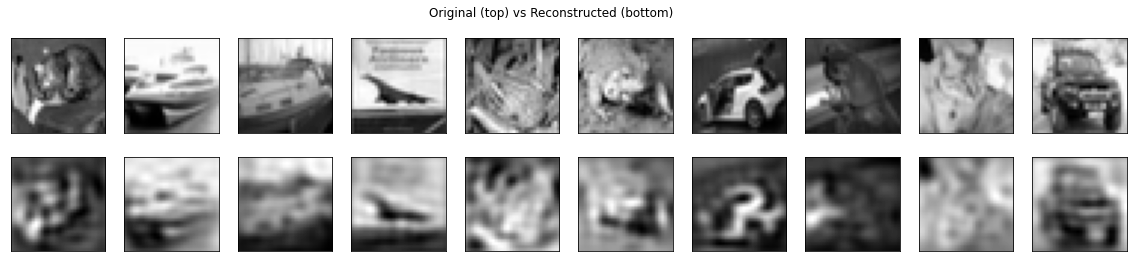

In [8]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]**: What happens by varying the `ENCODING_DIM`? Try it out and discuss the results in this cell.

_Answer:_ 

I did some tests with different encoding dimensions; the results are plotted in the cell below this one. 

Obviously, the higher the dimension space of the encoding, the better are the reconstruction of images, since an higher-dimension space preserves more salient features and information of the original image.

There is also a tradeoff between accuracy of reconstruction and training time; of course, the lower the dimension of the encoding, the lower are the dimensions of the matrices and so is the computation time to perform the singular value decomposition.

Encoding dim: 32
Training mse: 0.00980
Test mse: 0.00984


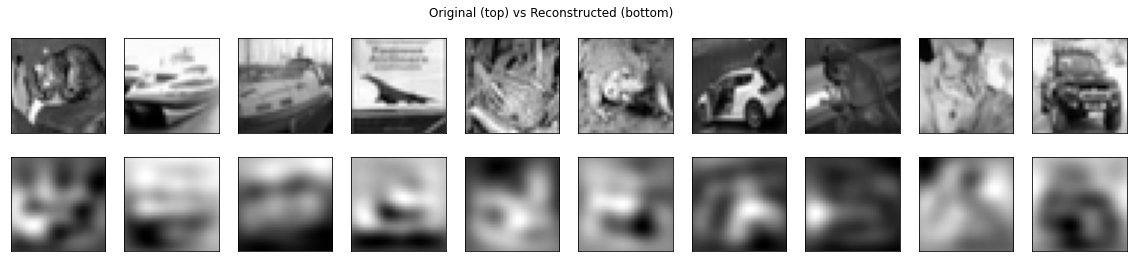

Encoding dim: 64
Training mse: 0.00628
Test mse: 0.00631


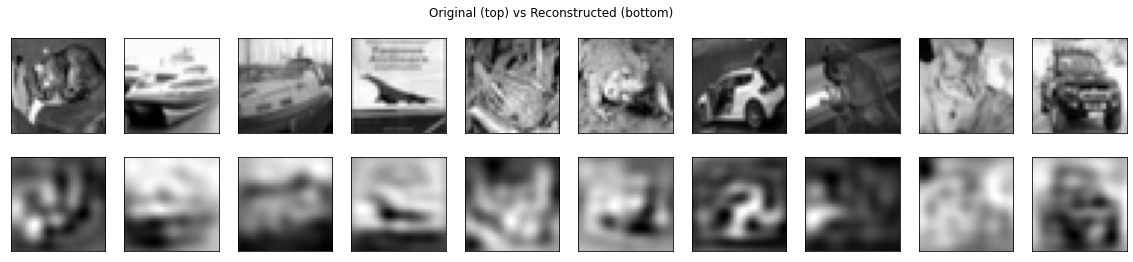

Encoding dim: 256
Training mse: 0.00150
Test mse: 0.00153


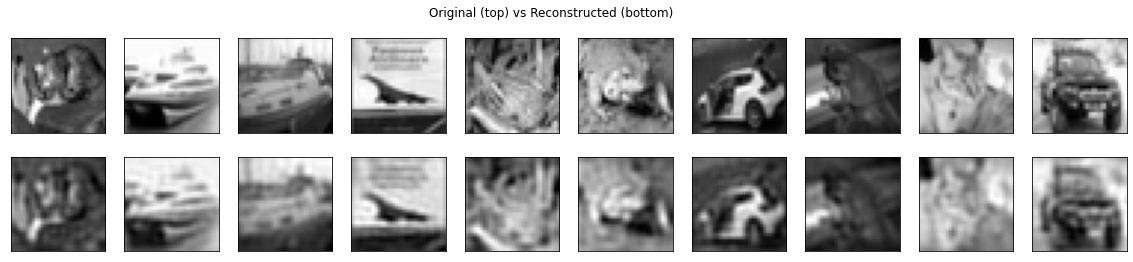

Encoding dim: 512
Training mse: 0.00037
Test mse: 0.00038


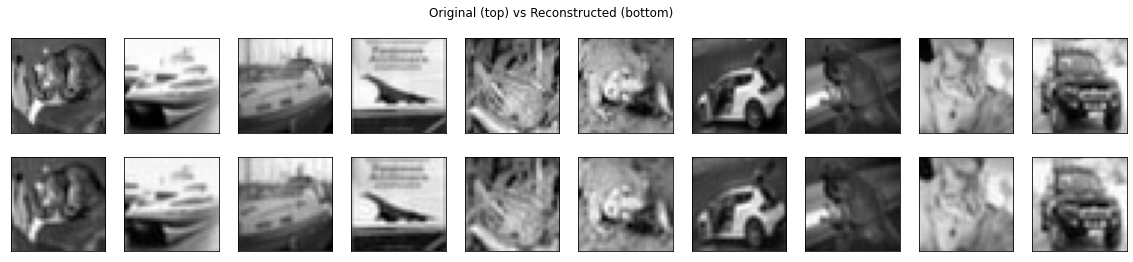

In [9]:
# Try SVD with different encoding dimension values

ENCODING_DIMS = [32, 64, 256, 512]

for dim in ENCODING_DIMS:

  U_k = SVD(x_train, dim)

  x_training_svd = np.dot(x_train, U_k)
  x_test_svd = np.dot(x_test, U_k)

  x_training_reco = np.dot(x_training_svd, U_k.T)
  x_test_reco = np.dot(x_test_svd, U_k.T)

  accuracy_train = ((x_train - x_training_reco)**2).mean()
  accuracy_test = ((x_test - x_test_reco)**2).mean()

  print("Encoding dim: %d" % (dim))
  print("Training mse: %.5f" % ( accuracy_train))
  print("Test mse: %.5f" % ( accuracy_test))

  plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous HW when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model. 


In [10]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

Print the model summary.

In [11]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [12]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 3s 9ms/step - loss: 0.1947 - val_loss: 0.0604
Epoch 2/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0307 - val_loss: 0.0234
Epoch 3/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0231 - val_loss: 0.0175
Epoch 4/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0165 - val_loss: 0.0144
Epoch 5/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0149 - val_loss: 0.0123
Epoch 6/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 7/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 8/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0090
Epoch 9/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 10/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.0078
Epoch 11/15
79/79 [

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [9]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 1s - loss: 0.0056 - 945ms/epoch - 3ms/step
Test mse: 0.00558


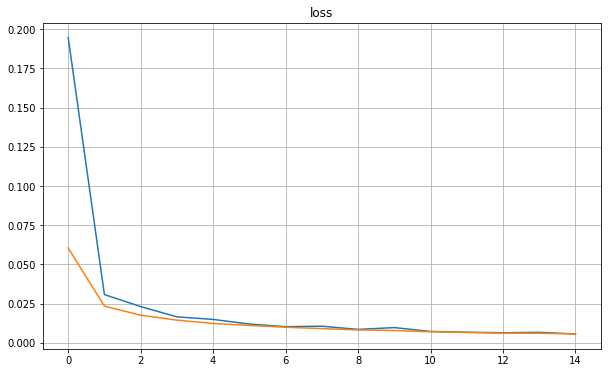

In [14]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

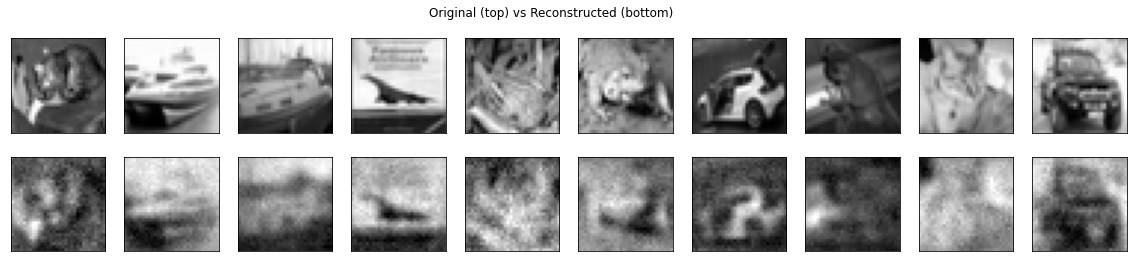

In [15]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]** Check the results and compare them versus the results obtained with the SVD. Give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


_Answer:_ 

Comparing the results on test set with same encoding dimension (256), we get:
- **SVD**, MSE: 0.00153
- **Shallow Linear Autoencoder,** MSE: 0.00558

The performance obtained by the SVD are way better, since the autoencoder model is a very simple one, shallow and with linear activations. I guess that changing the tunable hyperparameters of the AE model could reduce a little bit the error.

The performances of this type of AE are comparable with the ones of the SVD with a quite lower encoding dimension. 


##[TO COMPLETE] Exercise 5.3: Shallow Non-linear Autoencoders

**[TO COMPLETE]** Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. 

Insert your code and theoretical discussion into cells immediately below this one.


In [19]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))

encoded = tf.keras.layers.Dense(ENCODING_DIM, activation=tf.keras.layers.LeakyReLU())(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [20]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
79/79 [==============================] - 1s 8ms/step - loss: 0.0331 - val_loss: 0.0213
Epoch 2/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0181 - val_loss: 0.0145
Epoch 3/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0150 - val_loss: 0.0129
Epoch 4/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0137 - val_loss: 0.0091
Epoch 5/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0084
Epoch 6/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 7/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0061
Epoch 8/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0061
Epoch 9/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 10/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0066
Epoch 11/15
79/79 [

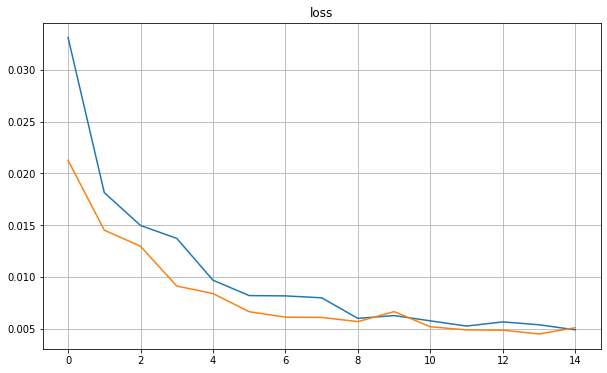

In [21]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

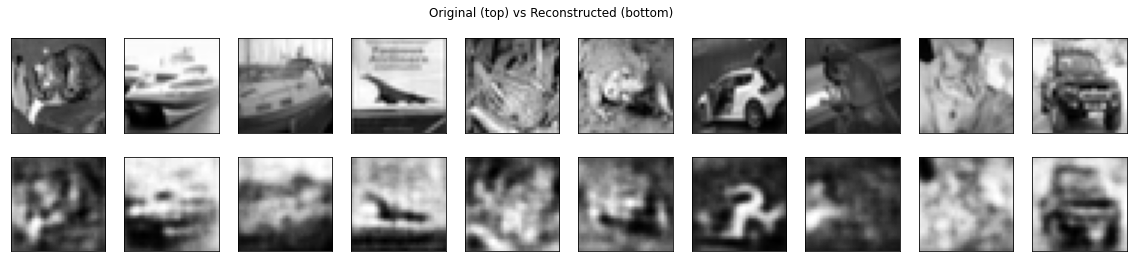

In [22]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

First of all, I chose to use the *leaky-relu* as non-linear activation function of the encoding layer, that is the one that performs better among the others I tried, since it doesn't "shrinks" the values in a small range (e.g. between 0 and 1 for the *sigmoid* and -1 and 1 for the *tanh*). 

In addition, I used the *sigmoid* as activation function for the decoding layer; it provides in output values in range between 0 and 1, predicting the value for each pixel in order to reconstruct the input. 

Performace comparison:
- **Shallow Linear Autoencoder,** MSE: 0.00558
- **Shallow Non-Linear Autoencoder,** MSE: 0.00506

We can note that the Non-Linear autoencoders perform better than the linear ones, so we were able to obtain an improvement.
<br>
The reason is that the power of non-linear function of getting the most salient features in a smaller space is more evident when using deep networks and architectures. 



##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]** Build a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [44]:
ENCODING_DIM = 256 # same as shallow AE, to perform comparisons

INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded_1 = tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU())(input_img)
encoded_2 = tf.keras.layers.Dense(384, activation=tf.keras.layers.LeakyReLU())(encoded_1)
encoded_3 = tf.keras.layers.Dense(ENCODING_DIM, activation=tf.keras.layers.LeakyReLU())(encoded_2)

decoded_1 = tf.keras.layers.Dense(384, activation=tf.keras.layers.LeakyReLU())(encoded_3)
decoded_2 = tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU())(decoded_1)
decoded_3 = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(decoded_2)

autoencoder = tf.keras.models.Model(input_img, decoded_3)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [45]:
autoencoder.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_48 (Dense)            (None, 512)               524800    
                                                                 
 dense_49 (Dense)            (None, 384)               196992    
                                                                 
 dense_50 (Dense)            (None, 256)               98560     
                                                                 
 dense_51 (Dense)            (None, 384)               98688     
                                                                 
 dense_52 (Dense)            (None, 512)               197120    
                                                                 
 dense_53 (Dense)            (None, 1024)              525

In [46]:
history = autoencoder.fit(x_train, x_train, epochs= 100, batch_size= 128, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/100
313/313 [==============================] - 2s 5ms/step - loss: 0.0241 - val_loss: 0.0154
Epoch 2/100
313/313 [==============================] - 1s 4ms/step - loss: 0.0129 - val_loss: 0.0114
Epoch 3/100
313/313 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0098
Epoch 4/100
313/313 [==============================] - 1s 4ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 5/100
313/313 [==============================] - 2s 5ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 6/100
313/313 [==============================] - 2s 5ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 7/100
313/313 [==============================] - 2s 5ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 8/100
313/313 [==============================] - 2s 5ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 9/100
313/313 [==============================] - 2s 5ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 10/100
313/313 [==============================] - 1s 5ms/step - loss: 0.0065 - val_lo

313/313 - 1s - loss: 0.0030 - 576ms/epoch - 2ms/step
test mse: 0.00305


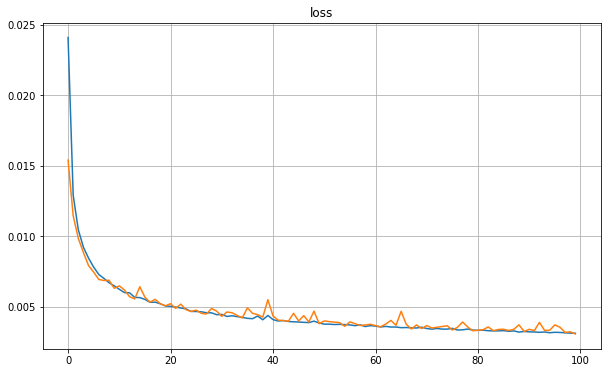

In [47]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

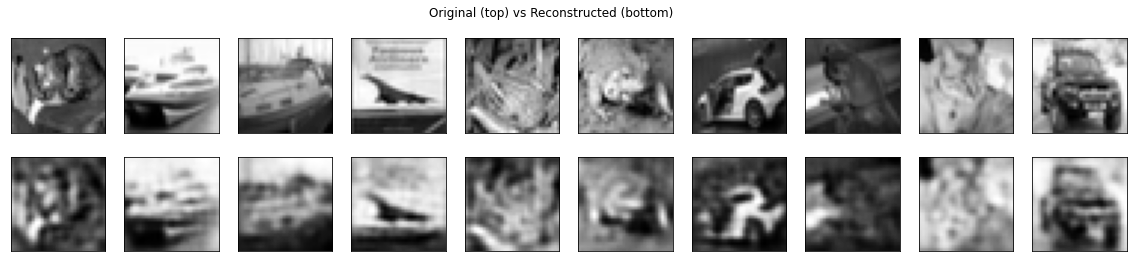

In [48]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

Overall performance comparison:
- **Shallow Linear Autoencoder,** MSE: 0.00558
- **Shallow Non-Linear Autoencoder,** MSE: 0.00506
- **Deep Non-Linear Autoencoder,** MSE: 0.00305

As we can see, we obtained a huge improvement with respect to shallow autoencoders architectures. In order to achieve this error, I changed the learning rate to 0.001, the batch size to 128 and set the number of epochs to 100, since there are way more parameters to learn.
<br>
I created the deep model with 7 levels, including the input layer, 4 for the encoder and 3 for the decoder. I did some tests and then I set the activation functions of the 3 encoding layers all to leaky relu (wiyh default parameters, i.e. alpha = 0.3), and for the decoding layers the first two the same leaky-relu and the last one to sigmoid to reconstruct the output (the reasoning is similar to the deep non-linear AE).

At the end of the day, we can note that the SVD is the most accurate model. This is because it is deterministic and works based on mathematical tools but, as we saw in class, an autoencoder architecure can perform very similar to the SVD.


## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [50]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

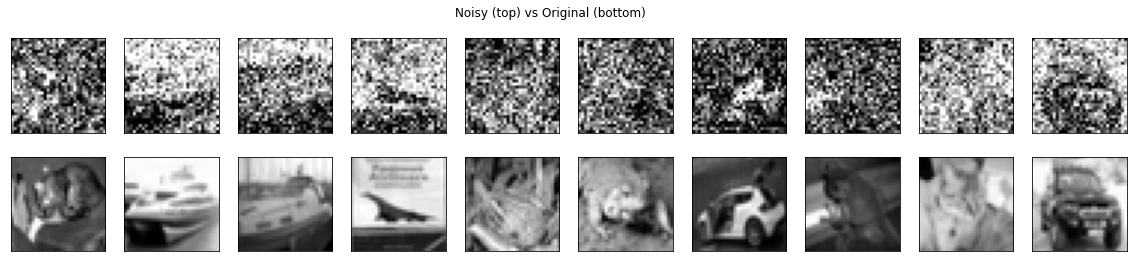

In [51]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$). 

In [56]:
ENCODING_DIM = 256

INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))

encoded = tf.keras.layers.Dense(ENCODING_DIM, activation=tf.keras.layers.LeakyReLU())(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [57]:
autoencoder.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_56 (Dense)            (None, 256)               262400    
                                                                 
 dense_57 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [58]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=20, batch_size=256, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/20
157/157 [==============================] - 1s 5ms/step - loss: 0.0332 - val_loss: 0.0236
Epoch 2/20
157/157 [==============================] - 1s 4ms/step - loss: 0.0203 - val_loss: 0.0212
Epoch 3/20
157/157 [==============================] - 1s 4ms/step - loss: 0.0165 - val_loss: 0.0148
Epoch 4/20
157/157 [==============================] - 1s 4ms/step - loss: 0.0142 - val_loss: 0.0139
Epoch 5/20
157/157 [==============================] - 1s 4ms/step - loss: 0.0133 - val_loss: 0.0127
Epoch 6/20
157/157 [==============================] - 1s 4ms/step - loss: 0.0127 - val_loss: 0.0123
Epoch 7/20
157/157 [==============================] - 1s 4ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 8/20
157/157 [==============================] - 1s 4ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 9/20
157/157 [==============================] - 1s 4ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 10/20
157/157 [==============================] - 1s 4ms/step - loss: 0.0116 - val_loss: 0.0115

313/313 - 1s - loss: 0.0109 - 515ms/epoch - 2ms/step
Test mse: 0.01092


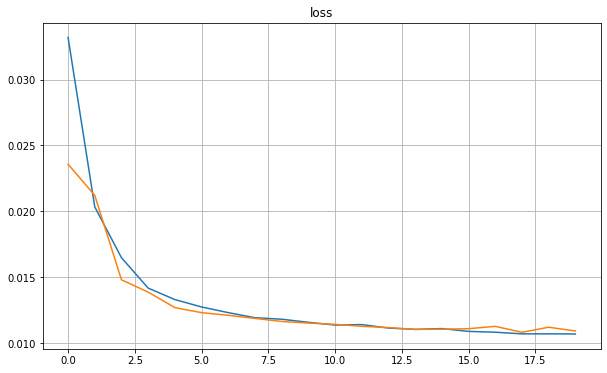

In [59]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

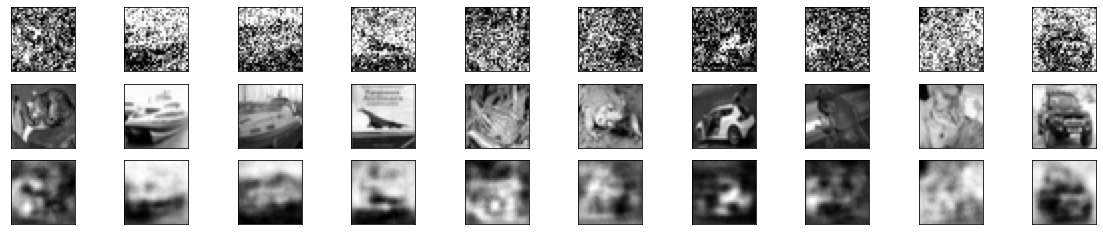

In [60]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs])

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [3]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

1654784/1641221 [==============================] - 0s 0us/step


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [4]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [12]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 90, 100)]         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 90, 50)            7550      
                                                                 
 time_distributed_2 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 6s 70ms/step - loss: 0.1610 - categorical_accuracy: 0.1837 - val_loss: 0.0849 - val_categorical_accuracy: 0.3604
Epoch 2/50
79/79 [==============================] - 5s 67ms/step - loss: 0.0725 - categorical_accuracy: 0.4100 - val_loss: 0.0657 - val_categorical_accuracy: 0.4605
Epoch 3/50
79/79 [==============================] - 5s 66ms/step - loss: 0.0609 - categorical_accuracy: 0.4833 - val_loss: 0.0575 - val_categorical_accuracy: 0.4990
Epoch 4/50
79/79 [==============================] - 5s 64ms/step - loss: 0.0533 - categorical_accuracy: 0.5268 - val_loss: 0.0504 - val_categorical_accuracy: 0.5349
Epoch 5/50
79/79 [==============================] - 5s 64ms/step - loss: 0.0471 - categorical_accuracy: 0.5559 - val_loss: 0.0451 - val_categorical_accuracy: 0.5567
Epoch 6/50
79/79 [==============================] - 5s 65ms/step - loss: 0.0416 - categorical_accuracy: 0.5770 - val_loss: 0.0399 - val_categorical_accuracy: 0.5785
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0107 - categorical_accuracy: 0.9377 - 350ms/epoch - 9ms/step
categorical_accuracy: 93.77%


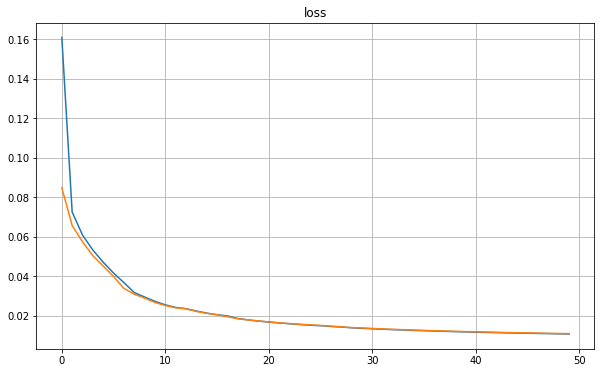

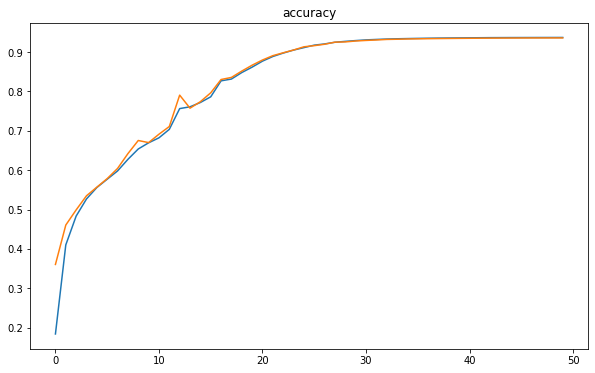

In [14]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [15]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
most a <oov> <oov> that are <oov> see all of that time but that <oov> the <oov> is <oov> a <oov> <oov> film it just about <oov> <oov> <oov> <oov> as her other <oov> have <oov> to it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> to the <oov> <oov> this is a really bad film that <oov> <oov> <oov> and its <oov> of <oov> <oov> i <oov> it <oov> or of <oov> and i <oov> <oov> them <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [26]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 90, 100)]         0         
                                                                 
 lstm_5 (LSTM)               (None, 90, 50)            30200     
                                                                 
 time_distributed_7 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=30, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/30
79/79 [==============================] - 3s 21ms/step - loss: 0.0430 - categorical_accuracy: 0.4474 - val_loss: 0.0373 - val_categorical_accuracy: 0.4625
Epoch 2/30
79/79 [==============================] - 1s 14ms/step - loss: 0.0358 - categorical_accuracy: 0.4726 - val_loss: 0.0349 - val_categorical_accuracy: 0.4639
Epoch 3/30
79/79 [==============================] - 1s 14ms/step - loss: 0.0325 - categorical_accuracy: 0.4768 - val_loss: 0.0306 - val_categorical_accuracy: 0.4927
Epoch 4/30
79/79 [==============================] - 1s 14ms/step - loss: 0.0279 - categorical_accuracy: 0.5003 - val_loss: 0.0259 - val_categorical_accuracy: 0.4946
Epoch 5/30
79/79 [==============================] - 1s 14ms/step - loss: 0.0233 - categorical_accuracy: 0.5640 - val_loss: 0.0213 - val_categorical_accuracy: 0.6372
Epoch 6/30
79/79 [==============================] - 1s 14ms/step - loss: 0.0189 - categorical_accuracy: 0.7127 - val_loss: 0.0170 - val_categorical_accuracy: 0.7477
Epoch 7/30

40/40 - 0s - loss: 1.0719e-04 - categorical_accuracy: 1.0000 - 214ms/epoch - 5ms/step
categorical_accuracy: 100.00%


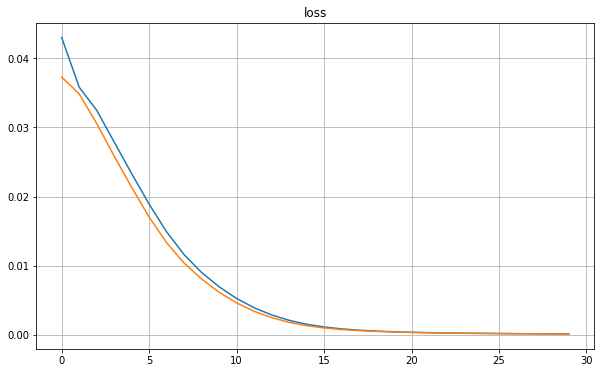

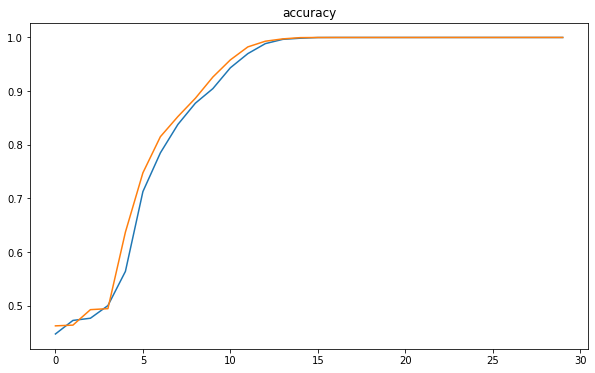

In [28]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [29]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


Performance Comparison:
- **Linear Autoencoder:** loss: 0.0072, accuracy: 93.77%
- **Non-Linear Autoencoder:** accuracy: 100%
  - *sigmoid*, loss: 1.3552e-04
  - *tanh*, loss: 1.2066e-04

As we can see, non-linear autoencoders performs better even for sequences task, since they are capable to extract more salient features in the latent space in order to perform learning and reconstruct the input.

The model is very powerful and is able to achieve a 100% accuracy, because we are exploiting both the power of the LSTM model rather than a simple RNN (as seen in HW4) and the non-linearity of the activation function.

I chose the *softmax* function as non-linear activation function of the decoding layer to the output to obtain a probabily distribution and select the most likely value to reconstruct the sentence. 